# Modelling

In [14]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import random
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import modelling as ml
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import pickle
import gzip, pickle, pickletools
import shap

sns.set_theme(context='notebook', style='darkgrid', palette='Set3')

In [15]:
# Import label encoded and ready for modelling set from 02 file 
df = pd.read_csv('../data/modelling_wines.csv')
df.set_index('name', inplace=True)
df.head()

,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,from_vivino,age,log_price,log_rating_qty,age^2,rating * log_rating_qty
name,,,,,,,,,,,,,,,,
Ruffino Il Leo Chianti Superiore 2017,55.0,10.0,30.0,5630.0,2.0,21.0,11.71,3.6,270.0,13.194986,1.0,7.0,2.460443,5.598422,49.0,20.154319
Darenberg The Love Grass Shiraz 2017,130.0,1.0,30.0,2433.0,0.0,107.0,19.99,3.7,235.0,13.574750,1.0,7.0,2.995232,5.459586,49.0,20.200466
Pittnauer Pitti 2018,34.0,2.0,31.0,5221.0,0.0,121.0,8.54,3.7,190.0,13.242475,1.0,6.0,2.144761,5.247024,36.0,19.413989
Darenberg The Footbolt Shiraz 2017,130.0,1.0,30.0,2433.0,2.0,107.0,12.37,3.7,792.0,12.553393,1.0,7.0,2.515274,6.674561,49.0,24.695877
Kendalljackson Vintners Reserve Cabernet Sauvignon 2018,199.0,20.0,31.0,3893.0,0.0,16.0,23.99,3.9,2805.0,13.745501,1.0,6.0,3.177637,7.939159,36.0,30.962719


In [16]:
# Chose to drop abv as it was highly imputed (70% of the data). Dropped from_vivino as it is not useful for production model or app.
df.drop(columns = ['abv', 'from_vivino'], inplace=True)

# Baseline Model

Basic Linear Regression with abv nulls imputed via linear regression. 

In [17]:
df.columns

Index(['region', 'country', 'vintage', 'producer', 'wine_variety',
       'grape_variety', 'price', 'rating', 'rating_qty', 'age', 'log_price',
       'log_rating_qty', 'age^2', 'rating * log_rating_qty'],
      dtype='object')

In [18]:
X = df.drop(columns = ['log_price', 'price', 'vintage'])
y = df['log_price']

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, random_state=42, train_size=0.85)

lr = LinearRegression()

lr.fit(X_train_lr, y_train_lr)
y_pred_lr = lr.predict(X_test_lr)

print(f"Price Root Mean Squared Error (RMSE): {round(np.exp(np.sqrt(mean_squared_error(y_test_lr, y_pred_lr))),3)}")
print(f"Log-Price Root Mean Squared Error (RMSE): {round(np.sqrt(mean_squared_error(y_test_lr, y_pred_lr)),3)}")
print(f"R-squared (R2): {round(r2_score(y_test_lr, y_pred_lr),3)}")
print(f"Cross validated r2: {round(cross_val_score(lr, X_train_lr, y_train_lr, cv = 10,scoring='r2').mean(), 3)}")

Price Root Mean Squared Error (RMSE): 1.674
Log-Price Root Mean Squared Error (RMSE): 0.515
R-squared (R2): 0.63
Cross validated r2: 0.631


In [19]:
# Put coefficients into a dataframe with index and columns
coef_df = pd.DataFrame(lr.coef_, X.columns, columns=['Coefficient'])
coef_df.sort_values(by=['Coefficient'], ascending=False, inplace=True)
coef_df

,Coefficient
rating,0.822022
rating * log_rating_qty,0.184546
age,0.129003
producer,-0.000015
rating_qty,-0.000039
grape_variety,-0.000100
region,-0.000169
age^2,-0.001967
country,-0.014513
wine_variety,-0.017660


* Model relying heavily on non-categorical coefficients - rating, rating *  log_rating_qty, age, log_rating_qty. 
* Logartithmic transformations proved to aid model predictivness for both price as a target and rating_qty.
* Categoricals which are label encoded grape_variety, producer, region, country performed poorly as to be expected with a linear regression model. Binary encoding was attempted of select categoricals, along with PCA to reduce dimensionality how ever best models proved to be decison tree based regressions with label encoding. 

In [20]:
results = ml.regression_model_selector(X_train_lr, y_train_lr, X_test_lr, y_test_lr, quick=True)
results

Not using StandardScaler


,model,rmse,cv,train_score,test_score,varience
0,lr,0.515122,0.631404,0.631832,0.629750,0.002082
1,ridge,0.515120,0.631405,0.631832,0.629753,0.002079
2,knn,0.539901,0.514289,0.762782,0.593273,0.169509
3,dt,0.311154,0.834365,0.999903,0.864909,0.134993


**Results of other models tested with same inputs:**
|index|model|rmse|cv|train_score|test_score|varience
|---|---|---|---|---|---|---|
|0|lr|0.523012|0.634073|0.634886|0.631206|0.003680|
|1|ridge|0.523014|0.634073|0.634886|0.631203|0.003683|
|2|knn|0.528168|0.539322|0.782727|0.623898|0.158828|
|3|dt|0.298107|0.847410|0.999962|0.880187|0.119775|
|4|RF|0.231445|0.910326|0.989422|0.927780|0.061641|
|5|adab|0.528435|0.634300|0.625589|0.623518|0.002071|
|6|svr|0.755754|0.239027|0.244181|0.229945|0.014235|


In [21]:
# results['date/desc'] = '7/3 | ABV imputed LR | Target: PRICE | Features: all features label encoded'
# model_tracker_current = pd.read_csv('../data/model_tracker.csv')
# model_tracker_current = pd.concat([model_tracker_current, results])
# model_tracker_current.to_csv('../data/model_tracker.csv', index=False)
# model_tracker_current

## Decision Tree Regression

In [22]:
# No hyper parameter tuning with a decision tree model. 

X_decision_trees = df.drop(columns = ['log_price', 'price', 'age', 'age^2'])

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_decision_trees, y, random_state=42, train_size=0.85)

dt = DecisionTreeRegressor(random_state=42)

dt.fit(X_train_dt, y_train_dt)

y_pred_dt = dt.predict(X_test_dt)

print(f"Log-price Root Mean Squared Error (RMSE): {(np.sqrt(mean_squared_error(y_test_dt, y_pred_dt)))}")
print(f"Price USD Root Mean Squared Error (RMSE): {(np.exp(np.sqrt(mean_squared_error(y_test_dt, y_pred_dt))))}")
print(f"R-squared (R2): {r2_score(y_test_dt, y_pred_dt)}")

Log-price Root Mean Squared Error (RMSE): 0.3076071077674414
Price USD Root Mean Squared Error (RMSE): 1.3601664850958413
R-squared (R2): 0.8679716676542122


Log-price Root Mean Squared Error (RMSE): 0.3076<br>
Price USD Root Mean Squared Error (RMSE): 1.3601<br>
R-squared (R2): 0.868<br>

In [23]:
dt = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth': [10, 50, 60, 70, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2]
}

gs = GridSearchCV(estimator=dt, param_grid=param_grid, 
                           cv=5, 
                           verbose=0, n_jobs=-1)

gs.fit(X_train_dt, y_train_dt)

print("Best params: ", gs.best_params_)
print("Best score: ", gs.best_score_)

best_model = gs.best_estimator_

y_pred_dt_gs = best_model.predict(X_test_dt)
mse = mean_squared_error(y_test_dt, y_pred_dt_gs)
print(f"Test log Price RMSE: {np.sqrt(mse)}")
print(f"Test Price USD RMSE: {np.exp(np.sqrt(mse))}")

# Best params:  {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 5}
# Best score:  0.8370318138131483
# Test log Price RMSE: 0.30905817405895775
# Test Price USD RMSE: 1.3621416095048726

Best params:  {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best score:  0.8370318138131483
Test log Price RMSE: 0.30905817405895775
Test Price USD RMSE: 1.3621416095048726


In [24]:
# After hyper parameter tuning
best_model.fit(X_train_dt, y_train_dt)
y_pred_dt_tuned = best_model.predict(X_test_dt)

print(f"Price Root Mean Squared Error (RMSE): {round(np.exp(np.sqrt(mean_squared_error(y_test_dt, y_pred_dt_tuned))),3)}")
print(f"Log-price Root Mean Squared Error (RMSE): {round(np.sqrt(mean_squared_error(y_test_dt, y_pred_dt_tuned)),3)}")
print(f"R-squared (R2): {round(r2_score(y_test_dt, y_pred_dt_tuned),3)}")
print(f"Cross validated r2: {round(cross_val_score(best_model, X_train_dt, y_train_dt, cv = 5).mean(), 3)}")

Price Root Mean Squared Error (RMSE): 1.362
Log-price Root Mean Squared Error (RMSE): 0.309
R-squared (R2): 0.867
Cross validated r2: 0.837


In [25]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(10):
    print(f"{f + 1}. feature {X_decision_trees.columns[indices[f]]} ({importances[indices[f]]:.3f})")

Feature ranking:
1. feature rating (0.566)
2. feature vintage (0.123)
3. feature region (0.071)
4. feature producer (0.064)
5. feature country (0.062)
6. feature rating * log_rating_qty (0.033)
7. feature grape_variety (0.027)
8. feature log_rating_qty (0.024)
9. feature rating_qty (0.024)
10. feature wine_variety (0.006)


## Random Forests Regression 

In [26]:
# # Commented out for reproducibility speed.
# np.random.seed(42)
# rf = RandomForestRegressor()
# param_grid = {
#     'max_depth': [120, 150],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1]
# }

# gs = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=5, verbose=0, n_jobs=-1)

# gs.fit(X_train_dt, y_train_dt)

# print("Best params: ", gs.best_params_)
# print("Best score:", gs.best_score_)
# rf_best_model = gs.best_estimator_

# y_pred_rf = rf_best_model.predict(X_test_dt)
# mse = mean_squared_error(y_test_dt, y_pred_rf)

# print(f"Price Root Mean Squared Error (RMSE): {round(np.exp(np.sqrt(mse)),3)}")
# print(f"Log-price Root Mean Squared Error (RMSE): {round(np.sqrt(mse),3)}")
# print(f"R-squared (R2): {round(r2_score(y_test_dt, y_pred_rf),3)}")
# print(f"Cross validated r2: {round(cross_val_score(rf_best_model, X_train_dt, y_train_dt, cv = 5).mean(), 3)}")



Best params:  {'max_depth': 120, 'min_samples_leaf': 1, 'min_samples_split': 2}<br>
Best score: 0.9023414270094839<br>
Price Root Mean Squared Error (RMSE): 1.272<br>
Log-price Root Mean Squared Error (RMSE): 0.24<br>
R-squared (R2): 0.919<br>

In [29]:
# Commented out for reproducibility speed.
np.random.seed(42)
rf = RandomForestRegressor(max_depth = 120, min_samples_leaf = 1, min_samples_split = 2)

rf_best_model = rf.fit(X_train_dt, y_train_dt)

y_pred_rf = rf_best_model.predict(X_test_dt)
mse = mean_squared_error(y_test_dt, y_pred_rf)

print(f"Price Root Mean Squared Error (RMSE): {round(np.exp(np.sqrt(mse)),3)}")
print(f"Log-price Root Mean Squared Error (RMSE): {round(np.sqrt(mse),3)}")
print(f"R-squared (R2): {round(r2_score(y_test_dt, y_pred_rf),3)}")
#print(f"Cross validated r2: {round(cross_val_score(rf_best_model, X_train_dt, y_train_dt, cv = 5).mean(), 3)}")

Price Root Mean Squared Error (RMSE): 1.272
Log-price Root Mean Squared Error (RMSE): 0.24
R-squared (R2): 0.919
Cross validated r2: 0.902


In [30]:
# Results 
# Best parameters found:  {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2}
# Best score: -0.06420003624506912
# Test RMSE: 1.3501831006951108
# R-squared (R2): 0.878
# Cross validated r2: 0.92

### Model Comparison: 
**Linear Regression**<br>
Price (USD) Root Mean Squared Error (RMSE): 1.687<br>
Log-price Root Mean Squared Error (RMSE): 0.523<br>
R-squared (R2): 0.631<br>
Cross validated r2: 0.634<br>

**Decision Tree Regression** - (Best parameters found:'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5)<br>
Price (USD) Root Mean Squared Error (RMSE): 1.35<br>
Log-price Root Mean Squared Error (RMSE): 0.3<br>
R-squared (R2): 0.878<br>
Cross validated r2: 0.851<br>

**Random Forests Regression** - (Best parameters found:'max_depth': 120, 'min_samples_leaf': 1, 'min_samples_split': 2)<br>
Price Root Mean Squared Error (RMSE): 1.272<br>
Log-price Root Mean Squared Error (RMSE): 0.24<br>
R-squared (R2): 0.919<br>
Cross validated r2: 0.902<br>

# Feature Importance of Decision Tree Model

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


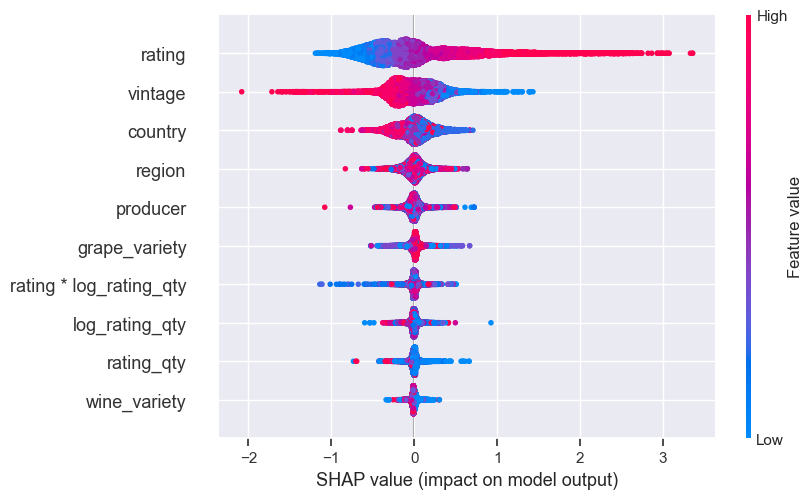

In [31]:
# taking hours to run for some reason 
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train_dt)
shap.plots.beeswarm(shap_values);

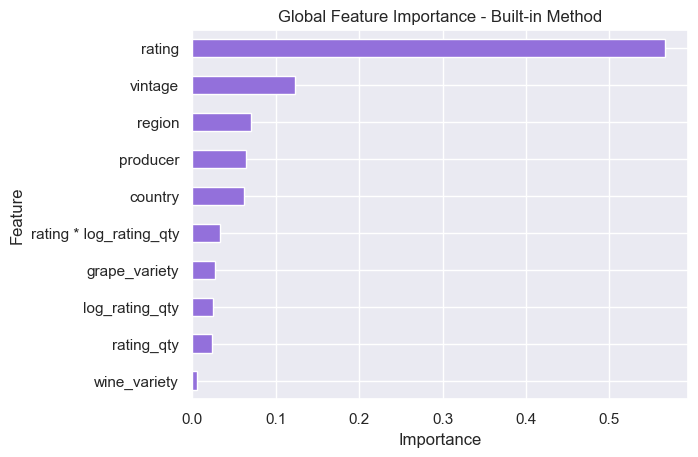

In [32]:
# code from https://forecastegy.com/posts/feature-importance-in-random-forests/
global_importances = pd.Series(best_model.feature_importances_, index=X_train_dt.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='mediumpurple')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method");

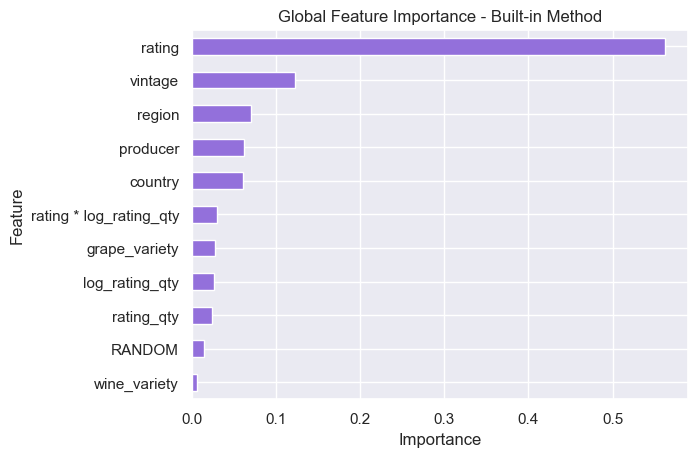

In [33]:
# Verifying feature importance with a comparison to a random variable
# code from https://forecastegy.com/posts/feature-importance-in-random-forests/

X_train_random = X_train_dt.copy()
X_train_random["RANDOM"] = np.random.RandomState(42).randn(X_train_dt.shape[0])

dtree_random_feat_imp = DecisionTreeRegressor(max_depth = None, min_samples_leaf = 1, min_samples_split = 3, random_state=42)
dtree_random_feat_imp.fit(X_train_random, y_train_dt)

global_importances_random = pd.Series(dtree_random_feat_imp.feature_importances_, index=X_train_random.columns)
global_importances_random.sort_values(ascending=True, inplace=True)
global_importances_random.plot.barh(color='mediumpurple')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method");

## Recursive Feature Elimination

Recursive Feature Elimination (RFE) - as another method to see most important features in the dataset.

In [34]:
ref_model = RFE(estimator=best_model, n_features_to_select=5, step=1)
ref_model.fit(X_train_dt, y_train_dt)

print("Feature ranking (1 indicates selected):", ref_model.ranking_)
print("Mask of selected features:", ref_model.support_)

selected_features = X_decision_trees.columns[ref_model.support_]
print("Selected features:", selected_features)

Feature ranking (1 indicates selected): [1 2 1 1 6 4 1 3 5 1]
Mask of selected features: [ True False  True  True False False  True False False  True]
Selected features: Index(['region', 'vintage', 'producer', 'rating', 'rating * log_rating_qty'], dtype='object')


**Decision Trees Features Ranking (1 feature to select)**<br>
Feature ranking (1 indicates selected): [2 1 1 1 7 4 1 1 5 6 3]<br>
Mask of selected features: [False  True  True  True False False  True  True False False False]<br>
Selected features: Index(['country', 'vintage', 'producer', 'rating', 'rating_qty'], dtype='object')<br>

**Random Forests Features Ranking (5 features to select)**<br>
Feature ranking (1 indicates selected): [1 4 1 1 7 5 1 1 3 6 2]<br>
Mask of selected features: [ True False  True  True False False  True  True False False False]<br>
Selected features: Index(['region', 'vintage', 'producer', 'rating', 'rating_qty'], dtype='object')<br>

#

# Exporting files for the App

In [35]:
filepath = '../models/casi_dt_production.pkl'
with gzip.open(filepath, "wb") as f:
    pickled = pickle.dumps(best_model)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)

In [37]:
filepath = '../models/casi_rf_production.pkl'
with gzip.open(filepath, "wb") as f:
    pickled = pickle.dumps(rf_best_model)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)

## Sandbox

In [ ]:
# SAND BOX RUN FROM HERE 

df_backend = pd.read_csv('../data/app_backend.csv')
df_frontend = pd.read_csv('../data/app_frontend.csv')

# Select a random row
random_index = random.randint(0, len(df_backend) - 1)
random_row_b = df_backend.loc[random_index]
random_row_f = df_frontend.loc[random_index]

In [ ]:
model = dt_tuned
X_with_price = random_row_b.to_frame().transpose()
X_with_price

NameError: name 'dt_tuned' is not defined

In [ ]:
X = X_with_price.drop(['log_price'], axis = 1)
X

,region,country,vintage,producer,wine_variety,grape_variety,rating,rating_qty,abv,from_vivino,age
1730,270.0,0.0,38.0,2412.0,2.0,146.0,3.5,63.0,12.419702,1.0,5.0


In [ ]:
real_price = float(round(np.exp(X_with_price['log_price']), 2).iloc[0])
real_price


8.15

In [ ]:
casi_answer =  float(round(np.exp(model.predict(X)[0]),2))
casi_answer

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- abv
- age
- from_vivino
Feature names seen at fit time, yet now missing:
- log_rating_qty
- rating * log_rating_qty
